<h1><center>Finding the Best Neighborhoods in Toronto to Live In as well as to Open a South Asian Restaurant using Unsupervised Learning</center></h1>

<h2><center>Capstone Project - IBM Data Science Professional Certificate</center></h2>


<h2><center>Introduction</center></h2>

### Problem:
A client just moved from ‘Karachi, Pakistan’ to ‘Toronto, Canada’ and wants to open a high-end Asian restaurant there. So, he came to me with following 3 requirements:
1. Help him explore the city.
2. Find him the most suitable neighborhood to live in. He wants to live in a neighborhood as similar as possible to his old neighborhood in Karachi, Pakistan.
3.	Find him the optimal neighborhood to open his high-end Asian restaurant.

*Disclaimer: This is a hypothetical scenario.*

### Potential Audience:
1. Anyone who is planning to move to Toronto. This is an example for people moving from Karachi to Toronto but the similar analysis can be done for any other pair of cities.
2. Anyone who wants to explore Toronto.
3. Anyone who wants to open a restaurant in Toronto. We did analysis for an high-end Asian restaurant but similar analysis can be done for any other kind of resatuarant as well as for any other kind of business.


### Proposed Solution: 
As our problem has two parts, so, let us tackle each part separately. I proposed following solutions, respectively, for each part:
1. Build a data set comprising of venues located in each neighborhood of 'Toronto, Canada' and then cluster neighborhoods based on common venue types present there. This would give client quite good understanding about distribution of venues throughout the Toronto and would help him explore the city.
2. Include client's present neighborhood (along with veneus located there) in the aforementioned data set and cluster this data set on basis of common venue categories (like we did for problelm 1). Now filter out the cluster which includes client's present neighborhood (let's call it X) from this data set and cluster it (X). Repeat the same steps again until the number of neighborhoods in X fall below a threshold value (i.e. 15 or 20 etc). This would give client a good set of suitable neighborhoods to live in. 
3. Best neighborhood for a restaurant depends on multiple factors, i.e. demographic overview of the location i.e. average age, average income, population, distribution of ethnic groups, plans for neighborhood’s future development, and competition. 

    As we are opening a high-end Asian restaurant, so an ideal neighborhood would be the one with:
     * high average household income (indicates high buying power), 
     * high percentage of Asian population (assuming that Asian population is more inclined towards Asian cuisine), 
     * moderate number of competitors because if number of competitors are low in your restaurant’s neighborhood, it’s very unlikely that people would come there to try your cuisine especially when the restaurant would be new and if the number of competitors are very high, it would be relatively difficult to compete with them i.e. you would have to come up with a very strong USP (unique selling point). So, moderate number of competitors mean that people come to this neighborhood for Asian cuisine and it’s also not very difficult to deal with the completion here.


### Data Sources:
1.  Clinet provided his present address.
2.	Neighborhoods of Toronto, along with their postal codes would be scraped from [Wikipedia](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) respectively.
3.	A geocoding library [Geopandas](https://geopandas.org/) would be used to get geocoordinates of each neighborhood.
4.	These geocoordinates would then be used to extract top 100 venues in each neighborhood within 500m radius (as 500m is a reasonable walking distance) using [Foursquare](https://developer.foursquare.com/) API.
5.	Toronto’s demographic data is obtained from [Toronto's Open Data Portal](https://open.toronto.ca/).

### How we will use this data?

For problem 1:
1. Using postal codes (scraped from Wikipedia) and Geocoder library we will get geocoordinates of all the neighborhoods.
2. Then providing Foursquare API with these geocoordinates, we will get top 100 venues in each neighborhood within 500m radius.
3. We will then group this data by ‘venue category’ to get an estimate of frequency of each venue category in each neighborhood.
4. Then, we will cluster neighborhoods based on this frequency of venue categories to group similar neighborhoods together.

For problem 2:
1. Add client's present neighborhood data into the data set built for problem 1 and cluster it.
2. Filter out the cluster from this data set which includes client's presnet neighborhood (let's call it X).
3. Now, cluster X and go to the step 2 again.
4.  Repeat this process until number of neighborhoods in X fall below a threhold value (i.e. 15 or 20)

For problem 3: 
1. From the data collected for problem 1, we will build a new data set comprising of total number of Asian restaurants in each neighborhood along with neighborhood names and postal codes.
2. From Toronto’s demographics data, we will get Asian population, total population, number of high earning households, and average household income of each neighborhood. 
3. We will then cluster neighborhoods on basis of these parameters and will choose a cluster of neighborhoods closest to the ideal neighborhood (mentioned earlier).


### Importing Required Libraries


In [1]:
# Data structres libraries
import pandas as pd
import numpy as np 

# Grpahing libraries
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
mpl.style.use('ggplot') # optional: for ggplot-like style
import seaborn as sns

# Modelling liraries
from sklearn.cluster import KMeans # For clustering neighborhoods
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Analysis library, will be used for choosing best k for KMeans
from yellowbrick.cluster import KElbowVisualizer

# Map Rendering library
import folium

# Other libraries
from geopandas.tools import geocode # For converting addresses to their respective geocoordinates
import requests # For handling requests
import copy # For making different kind of copies i.e. deep copies/ shallow copies
import time # For handling delays

C:\ProgramData\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


<h2><center>Problem 01: Exploring Toronto</center></h2>

### 1. Extracting Neighborhoods' Data 
(Postal Code, Borough, Name and Geocoordinates)

Getting client's present neighborhood's geocoordinates using Geopandas.

In [2]:
# Client's present address
client_addr = '75600, Clifton, Karachi, Pakistan'
print('Client\'s present address: {}'.format(client_addr))

# Converting it into a DataFrame
client_addr = pd.DataFrame({'Postal Code':['75600'],'Neighborhood':['Clifton']})

# Getting geocoordinates of client's address
addr = client_addr['Postal Code'] + ', ' + client_addr['Neighborhood'] + ', Toronto' + ', Canada'
geo = geocode(addr, provider='nominatim', user_agent='autogis_xx', timeout=4)
client_addr['Latitude'] = geo['geometry'].y
client_addr['Longitude'] = geo['geometry'].x

client_addr.head()

Client's present address: 75600, Clifton, Karachi, Pakistan


,Postal Code,Neighborhood,Latitude,Longitude
0,75600,Clifton,43.758555,-79.464375


Scraping Wikipedia for Toronto's Neighborhood data

In [3]:
toronto = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
toronto[0]

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


Cleaning Toronto's Data and storing it into a Panda's DataFrame

In [4]:
# As all the required data is in toronto[0], so, lets' build a clean DataFrame now.
to_neigh = toronto[0] 

#Changing spellings of Neighborhoods (column name) to mantain consistency
to_neigh.rename({'Neighbourhood' : 'Neighborhood'}, axis = 'columns', inplace = True)

print("Shape of raw DataFrame: {}".format(to_neigh.shape))

# Removing row with unassinged boroughs
to_neigh.drop(to_neigh[to_neigh['Borough'] == 'Not assigned'].index, inplace = True, axis = 0)

# Now replacing neighborhood with boroughs where neighborhoods are unassigned.
to_neigh.loc[(to_neigh['Neighborhood'] == 'Not assigned'), 'Neighborhood'] = to_neigh['Borough']

# Dropping Borough column as we don't need this and resetting columns' order to mantain consistency
to_neigh.drop(columns = 'Borough', inplace = True)

# Resetting index
to_neigh.reset_index(inplace = True)
to_neigh.drop(columns = 'index', inplace = True)
print('Shape of clean DataFrame: {}'.format(to_neigh.shape))
to_neigh.head()

Shape of raw DataFrame: (180, 3)
Shape of clean DataFrame: (103, 2)


,Postal Code,Neighborhood
0,M3A,Parkwoods
1,M4A,Victoria Village
2,M5A,"Regent Park, Harbourfront"
3,M6A,"Lawrence Manor, Lawrence Heights"
4,M7A,"Queen's Park, Ontario Provincial Government"


Getting geocoordinates of Toronto's neighborhoods and storing it into a .csv file for future use as Geopandas is quite unreliable for large data sets

In [5]:
## Creating a list of addresses to pass to geocoder()
#addr = to_neigh['Postal Code'] + ', ' + to_neigh['Neighborhood'] + ', Toronto' + ', Canada'
#addr = pd.DataFrame(addr)
#geo = geocode(addr[0], provider='nominatim', user_agent='autogis_xx', timeout=6)

## Adding new columns to original toronto's DataFrame (to_neigh)
#to_neigh['Latitude'] = geo['geometry'].y
#to_neigh['Longitude'] = geo['geometry'].x

## Saving this DataFrame locally because geocode() is very unreliable. So, for future, we can read this clean DataFrame directly.
#to_neigh.to_csv('Torontos Neighborhoods with Geocoordinates.csv')

Reading the .csv file created in the previous cell

In [6]:
#Reading the saved Toronto's DataFrame
to_neigh = pd.read_csv(r'Torontos Neighborhoods with Geocoordinates.csv')

# We need to drop this additional column Unnamed: 0 
to_neigh.drop(columns = ['Unnamed: 0'], inplace = True)

print('Shape of Toronto\'s DataFrame is: {}'.format(to_neigh.shape))
to_neigh.head()

Shape of Toronto's DataFrame is: (103, 4)


,Postal Code,Neighborhood,Latitude,Longitude
0,M3A,Parkwoods,43.753259,-79.329656
1,M4A,Victoria Village,43.725882,-79.315572
2,M5A,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Creating a temporary DataFrame(df) by adding client's present address at the bottom of to_neigh to pass all under inspection neighborhoods to Foursqaure

In [7]:
df = pd.concat([to_neigh, client_addr], axis = 0).reset_index().drop(columns = ['index'])
df

,Postal Code,Neighborhood,Latitude,Longitude
0,M3A,Parkwoods,43.753259,-79.329656
1,M4A,Victoria Village,43.725882,-79.315572
2,M5A,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...
99,M4Y,Church and Wellesley,43.665860,-79.383160
100,M7Y,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509
102,M8Z,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999


### 2. Getting Venues Located in Each Neighborhood

Setting variables for my Foursquare credentials

In [8]:
CLIENT_ID = 'GUUCORHSKBKU0EYPOMDW2RAIYV4Y5KXFQKA2EIU4FWOOKYQW' # your Foursquare ID
CLIENT_SECRET = 'UNKAZH4AI1ZWMWHCXIZNC0LE0JO2JXQ0NE2330FQ3S3C0P2I' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Defining a function to get top 100 venues within 500m radius of all neighborhoods

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
                
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Using the aforementioned function to get required venues of all neighborhoods

In [10]:
venues = getNearbyVenues(names=df['Neighborhood'], latitudes=df['Latitude'], longitudes=df['Longitude'])
print('\n\nShape of venues DataFrame is: {}'.format(venues.shape))
venues.head()



Shape of venues DataFrame is: (2133, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


### 3. One-Hot Encoding of 'Venue Categories' 

Because 'Venue Categories' is in tabular form but we need it in numeric form to perform clustering, so we convert it into numeric form using one-hot encoding.

In [11]:
# One hot encoding the venues (to_venues + khi_venues) DataFrame

# One hot encoding of Venue Category
venues_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# Adding Neighborhood column back
venues_onehot['Neighborhood'] = venues['Neighborhood']

# Rearranging columns to bring Neihgborhood the first column
venues_onehot = venues_onehot[[venues_onehot.columns[-1]] + list(venues_onehot.columns[0:-1])]

print('Shape of DataFrame after one hot encoding: {}'.format(venues_onehot.shape))
venues_onehot.head()

Shape of DataFrame after one hot encoding: (2133, 269)


,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Grouping neigh_onehot by Neighborhood
venues_grouped_by_neigh = venues_onehot.groupby('Neighborhood').sum()
venues_grouped_by_neigh.reset_index(inplace = True)
venues_grouped_by_neigh.head()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Alderwood, Long Branch",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bayview Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Bedford Park, Lawrence Manor East",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 4. Preliminary analysis of Toronto's Neighborhoods' Venues Profile

Getting overview of DataFrame

In [13]:
venues[venues['Neighborhood'] != 'Clifton'].describe(include = 'all')

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
count,2124,2124.000000,2124.000000,2124,2124.000000,2124.000000,2124
unique,95,NaN,NaN,1376,NaN,NaN,269
top,"Commerce Court, Victoria Hotel",NaN,NaN,Starbucks,NaN,NaN,Coffee Shop
freq,100,NaN,NaN,62,NaN,NaN,189
mean,NaN,43.673640,-79.388659,NaN,43.673718,-79.388600,NaN
std,NaN,0.041454,0.053225,NaN,0.041316,0.053283,NaN
min,NaN,43.602414,-79.615819,NaN,43.599152,-79.621765,NaN
25%,NaN,43.648198,-79.400049,NaN,43.648516,-79.400084,NaN
50%,NaN,43.657162,-79.381752,NaN,43.655528,-79.381596,NaN
75%,NaN,43.679557,-79.374846,NaN,43.678711,-79.372444,NaN


We can see here that 'Toronto Dominion Centre, Design Exchange' has the most number of venues and 'Strabucks' and 'Coffee Shop' are the most common venue and venue categories respectively.

Getting a barchart of top 30 most common venue categories to get an overview of what kind of veneus are most common in Toronto.

<AxesSubplot:title={'center':'Top 30 Most Common Venue Categories in All Subject Neighborhoods'}, xlabel='Frequency of Venue Categories', ylabel='Venue Category'>

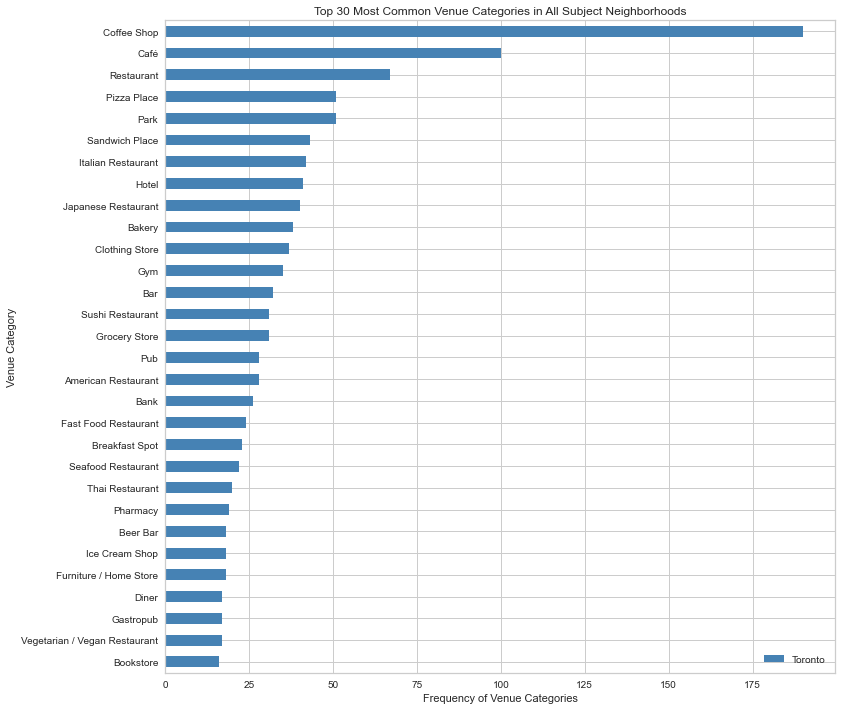

In [14]:
# Creating a temp df to visualize top 30 most common venue categories
temp = venues[venues['Neighborhood'] != 'Clifton'] # Removing Clifton from venues
temp = venues[['Venue Category', 'Neighborhood']]
temp = temp.groupby('Venue Category').count().reset_index()
temp = temp.sort_values('Neighborhood',ascending = True).reset_index().drop(columns = 'index')
temp = temp.tail(30)
temp.columns = ['Venue Category', 'Toronto']

# Plotting a bar chart for top 30 most common venue categories
plt.xlabel('Frequency of Venue Categories')
plt.title('Top 30 Most Common Venue Categories in All Subject Neighborhoods')
temp.plot(kind = 'barh', x = 'Venue Category', y='Toronto', figsize = (12,12), ax = plt.gca(), color = 'steelblue')

Now using a box plot to get an overview of frequency of all venue categories. This would tell us that in which frequency range most venue categories lie.

<AxesSubplot:title={'center':'Categories of  Venues in Toronto'}, ylabel='Frequency of Venue Categories'>

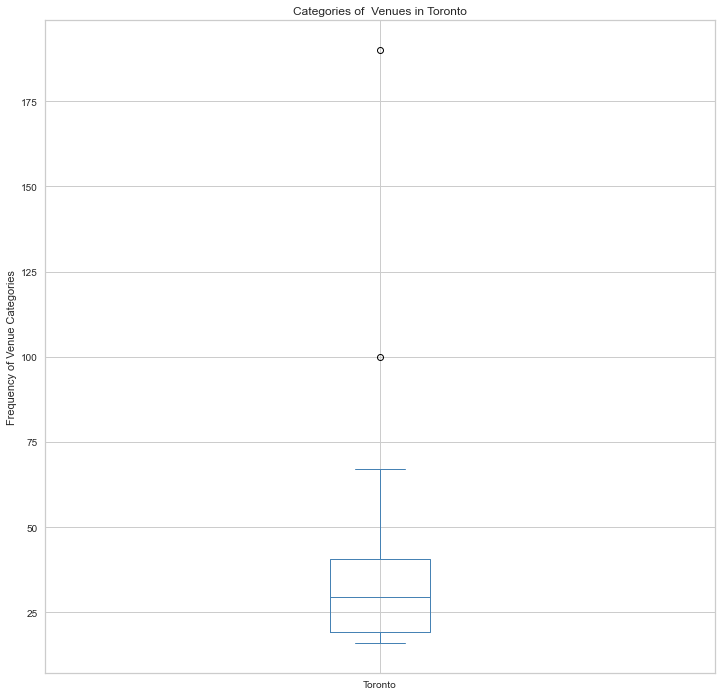

In [15]:
plt.ylabel('Frequency of Venue Categories')
plt.title('Categories of  Venues in Toronto')
temp.plot(kind = 'box', figsize = (12,12), ax = plt.gca(), color = 'steelblue')

Getting most common venue categories in each Neighborhood.

In [16]:
# A function to find the most common n venue categories for each neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
# Extracting top 10 most common venues of each neighborhood

# Because top 10
num_top_venues = 10

# For 1st, 22nd, 3rd in column names
indicators = ['st', 'nd', 'rd']

# Creating columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Creating a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venues_grouped_by_neigh['Neighborhood']

# Sorting all neighborhoods by their most common veneu categories
for ind in np.arange(venues_grouped_by_neigh.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped_by_neigh.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Latin American Restaurant,Lounge,Skating Rink,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
1,"Alderwood, Long Branch",Pizza Place,Gym,Coffee Shop,Pub,Sandwich Place,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Gift Shop,Fried Chicken Joint,Sandwich Place,Bridal Shop,Diner,Restaurant,Deli / Bodega,Supermarket
3,Bayview Village,Japanese Restaurant,Café,Bank,Chinese Restaurant,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
4,"Bedford Park, Lawrence Manor East",Restaurant,Sandwich Place,Coffee Shop,Italian Restaurant,Breakfast Spot,Indian Restaurant,Butcher,Café,Sushi Restaurant,Cupcake Shop


Making 'Neighborhood' column index in both DataFrames for easy access. 

In [18]:
# Making Neighborhood index in venues_grouped_by_neigh and neighborhoods_venues_sorted for easy access uisng pd.loc[]
venues_grouped_by_neigh.set_index('Neighborhood', inplace = True)
neighborhoods_venues_sorted.set_index('Neighborhood', inplace = True)

### 5. Clustering Toronto' Neighborhoods

Preprocessing data before performing clustering

In [19]:
# Removing Clifton, Karachi's Neighborhood (client's address) from venues DataFrame so that we could cluster only Toronto's Neighborhoods
x = venues_grouped_by_neigh[venues_grouped_by_neigh.index != 'Clifton']

# Scaling data to make its mean and sd 0 and 1 respectively. Scaling makes statistical analysis more accurate.
x = StandardScaler().fit_transform(x)

Choosing the best k using k-elbow method

C:\ProgramData\Anaconda3\envs\datascience\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


KElbowVisualizer(ax=<AxesSubplot:>, k=None, model=None)

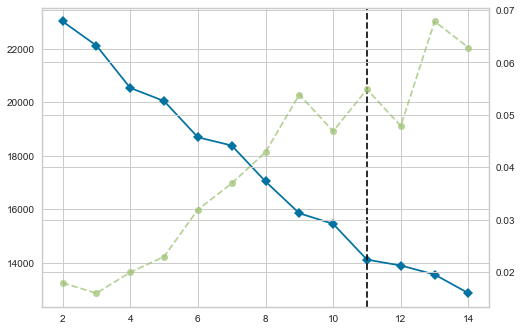

In [20]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15))

visualizer.fit(x)
visualizer


Clustering Toronto's neighborhoods using K-Means clustering

It seems like k = 8 would be the best k.

In [21]:
# Making a KMeans obejct with k number of clusters
k = 8 # Number of clusters

km = KMeans(n_clusters=k , init='k-means++') 

# Performing KMeans clustering on x
km.fit(x) 

KMeans()

Creating a new DataFrame including Neighborhoods' labels as well as other useful information.

In [22]:
# Creating a labelled Toronto's Neighborhood DataFrame

# Deep copying neighborhoods_venues_sorted DataFrame
to_neigh_labelled = copy.deepcopy(neighborhoods_venues_sorted[neighborhoods_venues_sorted.index != 'Clifton'])

# Adding columns Label (labels returned by KMeans) to to_neigh_labelled
to_neigh_labelled['Label'] = km.labels_

# Performing a join on Neighborhood with to_neigh
to_neigh_labelled = to_neigh_labelled.join(to_neigh.set_index('Neighborhood'), on='Neighborhood')

# Rearranging columns 
to_neigh_labelled = to_neigh_labelled[list(to_neigh_labelled.columns[10:]) +  list(to_neigh_labelled.columns[:10])]

print('Shape of Toronto\'s labelled DF: {}'.format(to_neigh_labelled.shape))
to_neigh_labelled.head()

Shape of Toronto's labelled DF: (99, 14)


,Label,Postal Code,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,,
Agincourt,0,M1S,43.794200,-79.262029,Breakfast Spot,Latin American Restaurant,Lounge,Skating Rink,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
"Alderwood, Long Branch",0,M8W,43.602414,-79.543484,Pizza Place,Gym,Coffee Shop,Pub,Sandwich Place,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
"Bathurst Manor, Wilson Heights, Downsview North",0,M3H,43.754328,-79.442259,Coffee Shop,Bank,Gift Shop,Fried Chicken Joint,Sandwich Place,Bridal Shop,Diner,Restaurant,Deli / Bodega,Supermarket
Bayview Village,0,M2K,43.786947,-79.385975,Japanese Restaurant,Café,Bank,Chinese Restaurant,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
"Bedford Park, Lawrence Manor East",0,M5M,43.733283,-79.419750,Restaurant,Sandwich Place,Coffee Shop,Italian Restaurant,Breakfast Spot,Indian Restaurant,Butcher,Café,Sushi Restaurant,Cupcake Shop


Displaying clusters on Toronto's map

In [23]:
# Displaying clustered lablelled Toronto's Neighborhood Data on map

# Toronto Lat/Lng
latitude = 43.6532
longitude = -79.3832

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_neigh_labelled['Latitude'], to_neigh_labelled['Longitude'], to_neigh_labelled.index, to_neigh_labelled['Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 6. Analyzing Clusters

#### Cluster 0

In [24]:
to_neigh_labelled.loc[to_neigh_labelled['Label'] == 0, :]

,Label,Postal Code,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,,
Agincourt,0,M1S,43.794200,-79.262029,Breakfast Spot,Latin American Restaurant,Lounge,Skating Rink,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
"Alderwood, Long Branch",0,M8W,43.602414,-79.543484,Pizza Place,Gym,Coffee Shop,Pub,Sandwich Place,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
"Bathurst Manor, Wilson Heights, Downsview North",0,M3H,43.754328,-79.442259,Coffee Shop,Bank,Gift Shop,Fried Chicken Joint,Sandwich Place,Bridal Shop,Diner,Restaurant,Deli / Bodega,Supermarket
Bayview Village,0,M2K,43.786947,-79.385975,Japanese Restaurant,Café,Bank,Chinese Restaurant,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
"Bedford Park, Lawrence Manor East",0,M5M,43.733283,-79.419750,Restaurant,Sandwich Place,Coffee Shop,Italian Restaurant,Breakfast Spot,Indian Restaurant,Butcher,Café,Sushi Restaurant,Cupcake Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Willowdale, Willowdale East",0,M2N,43.770120,-79.408493,Ramen Restaurant,Sushi Restaurant,Restaurant,Pizza Place,Café,Sandwich Place,Coffee Shop,Japanese Restaurant,Bubble Tea Shop,Electronics Store
"Willowdale, Willowdale West",0,M2R,43.782736,-79.442259,Grocery Store,Coffee Shop,Pharmacy,Pizza Place,Bank,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
Woburn,0,M1G,43.770992,-79.216917,Coffee Shop,Korean Restaurant,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Drugstore


#### Cluster 1

In [25]:
to_neigh_labelled.loc[to_neigh_labelled['Label'] == 1, :]

,Label,Postal Code,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,,
"Harbourfront East, Union Station, Toronto Islands",1,M5J,43.640816,-79.381752,Coffee Shop,Aquarium,Café,Hotel,Fried Chicken Joint,Scenic Lookout,Italian Restaurant,Brewery,Restaurant,Bank


#### Cluster 2

In [26]:
to_neigh_labelled.loc[to_neigh_labelled['Label'] == 2, :]

,Label,Postal Code,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,,
"Kensington Market, Chinatown, Grange Park",2,M5T,43.653206,-79.400049,Café,Coffee Shop,Vietnamese Restaurant,Mexican Restaurant,Vegetarian / Vegan Restaurant,Bar,Gaming Cafe,Bakery,Park,Pizza Place


#### Cluster 3

In [27]:
to_neigh_labelled.loc[to_neigh_labelled['Label'] == 3, :]

,Label,Postal Code,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,,
St. James Town,3,M5C,43.651494,-79.375418,Coffee Shop,Café,Clothing Store,Cocktail Bar,Cosmetics Shop,Restaurant,American Restaurant,Lingerie Store,Farmers Market,Seafood Restaurant


#### Cluster 4

In [28]:
to_neigh_labelled.loc[to_neigh_labelled['Label'] == 4, :]

,Label,Postal Code,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,,
"Commerce Court, Victoria Hotel",4,M5L,43.648198,-79.379817,Coffee Shop,Café,Restaurant,Hotel,Gym,American Restaurant,Seafood Restaurant,Japanese Restaurant,Bakery,Bar
"First Canadian Place, Underground city",4,M5X,43.648429,-79.382280,Coffee Shop,Café,Hotel,Restaurant,Gym,Japanese Restaurant,Seafood Restaurant,American Restaurant,Steakhouse,Asian Restaurant
"Richmond, Adelaide, King",4,M5H,43.650571,-79.384568,Coffee Shop,Café,Restaurant,Hotel,Gym,Clothing Store,Thai Restaurant,Steakhouse,Bar,Bookstore
"Toronto Dominion Centre, Design Exchange",4,M5K,43.647177,-79.381576,Coffee Shop,Hotel,Café,Restaurant,Salad Place,Italian Restaurant,Seafood Restaurant,American Restaurant,Japanese Restaurant,Asian Restaurant


### 6. Conclusion
We can see that a big majority of neighborhoods fall under one cluster (cluster 1). This cluster's most common venue categories are the ones fulfilling basic human needs. So, you can find almost any thing, you need on daily basis, in these neighborhoods. Other neighborhoods include, along with basic needs providing venues, some sort of special venues like bars or hotels etc. So, client can always refer to these clusters whenever he wants to visit a specific type of venue or wants to know the category of his target neighborhood.

<h2><center>Problem 02: Finding the Best Neighborhood to Live In</center></h2>

### 1. Clustering and Filtering Neighborhoods

Client's present neighborhood, 'Clifton, Karachi', is included in this DataFrame now, so, performing clustering and filtering consecutively in a loop untill number of neighborhoods in DataFrame (neigh_live_in) fall below a threshold of 20.

In [29]:
# Getting a list of required columns
col = venues_grouped_by_neigh.columns

# Removing Neighborhoods column
neigh_live_in = copy.deepcopy(venues_grouped_by_neigh[col]) 

# Initializing KMeans instance
km = KMeans(n_clusters=k , init='k-means++') 

# Performing clustering and filtering
for i in range(0,10):
    
    # Doing this becaiuse StandardScaler().fit_transform(x) outputs a Numpy arraya and I want to keep neigh_live_in as Pandas DataFrame
    x = neigh_live_in
    
    # Scaling data to make its mean and sd 0 and 1 respectively. It's important to make analysis accurate and effective.
    x = StandardScaler().fit_transform(x) 
    
    # Performing clustering on x
    km.fit(x) 
    
    # Adding labels to neigh_live_in
    neigh_live_in['Label'] = km.labels_
    
    # Filtering out the cluster which includes 'CLifton, Karachi'
    neigh_live_in = neigh_live_in[neigh_live_in['Label'] == neigh_live_in.loc['Clifton', 'Label']]
    
    # Condition to break the loop if number of neighborhoods in neigh_live_in falls below 20
    if neigh_live_in.shape[0] < 20:
        break
        

### 2. Displaying Optimal Neighborhoods on Map

Getting geocoordinates of these neighborhoods

In [30]:
# Joining these two DataFrames to get lat/lng columns in neigh_live_in
temp = pd.concat([to_neigh, client_addr], axis = 0) # Temp DataFrame to include client's present neighborhood too
neigh_live_in = neigh_live_in.join(temp.set_index('Neighborhood'), on='Neighborhood')

# Removing client's present neighborhood from this cluster
neigh_live_in = neigh_live_in[neigh_live_in.index != 'Clifton']

Displaying these neighborhoods on map using folium

In [31]:
# Displaying these Neighborhood on map

# Toronto Lat/Lng
latitude = 43.6532
longitude = -79.3832

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
#x = np.arange(k)
#ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neigh_live_in['Latitude'], neigh_live_in['Longitude'], neigh_live_in.index, neigh_live_in['Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 3. Optimal Neighborhoods to Live In

Following is a list of neighborhoods, along with common venue types there, suitable for client to live in.

In [32]:
neigh_live_in.reset_index(inplace = True)
neigh_live_in = neigh_live_in[['Neighborhood', 'Latitude', 'Longitude']]
neigh_live_in = neigh_live_in.join(neighborhoods_venues_sorted, on = 'Neighborhood')
neigh_live_in.set_index('Neighborhood', inplace = True)
neigh_live_in.head(neigh_live_in.shape[0])

,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,
"Steeles West, L'Amoreaux West",43.799525,-79.318389,Coffee Shop,Fast Food Restaurant,Chinese Restaurant,Pizza Place,Breakfast Spot,Sandwich Place,Bank,Electronics Store,Pharmacy,Grocery Store


<h2><center>Problem 03: Finding the Best Neighborhood to Open a High-End Asian Restaurant</center></h2>

### 1. Extracting Neighborhood's Data


Reading neighborhood profile downloaded from Toronto's Open Data Portal

In [33]:
# Reading Toronto's neighborhood profile downloaded 
neighborhood_profile = pd.read_csv(r'C:\Users\umerh\Documents\Jupytor Notebooks\Capstone Project - IBM DS Professional Certificate\neighbourhood-profiles-2016-csv.csv')
neighborhood_profile.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,...,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,4,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,5,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


Cleaning neighborhood profile and extracting required data

In [34]:
# Removing leading white spaces from this column. 
neighborhood_profile['Characteristic'] = neighborhood_profile['Characteristic'].str.lstrip()
neighborhood_profile['Topic'] = neighborhood_profile['Topic'].str.lstrip()

In [35]:
# Extracting total popualtion of Toronto as well as of each neighborhood.
tot_pop = neighborhood_profile[neighborhood_profile['Characteristic'] == 'Population, 2016'].reset_index().drop(columns = ['index'])
tot_pop.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"


In [36]:
# Extarcting total South Asian population (our target customers) in Toronto as well as in neighborhoods.
sa_pop = neighborhood_profile[neighborhood_profile['Characteristic'] == 'South Asian'].reset_index().drop(columns = ['index'])
sa_pop.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1338,Visible minority,Visible minority population,Census Profile 98-316-X2016001,South Asian,"338,965","5,315","4,190",540,"1,125",...,860,"2,340","21,545",610,345,255,445,560,"4,180",865


In [37]:
# Extracting household income profile of Toronto
hh_income = neighborhood_profile[neighborhood_profile['Topic'] == 'Income of households in 2015'].reset_index().drop(columns = ['index'])
hh_income.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,269,Income,Income of households in 2015,Census Profile 98-316-X2016001,"$150,000 to $199,999","77,810",595,475,560,"1,130",...,565,760,855,625,365,460,430,465,445,380
1,1015,Income,Income of households in 2015,Census Profile 98-316-X2016001,Median total income of one-person households i...,"38,018",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1018,Income,Income of households in 2015,Census Profile 98-316-X2016001,Total - Income statistics in 2015 for private ...,"1,112,930","9,120","8,130","4,620","15,940",...,"7,550","8,510","18,430","5,450","3,445","5,895","5,670","7,015","10,175","5,340"
3,1019,Income,Income of households in 2015,Census Profile 98-316-X2016001,Median total income of households in 2015 ($),"65,829",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1020,Income,Income of households in 2015,Census Profile 98-316-X2016001,Median after-tax income of households in 2015 ($),"58,264",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# We can see that row 0 with 'Characteristic' = '150,000 𝑡𝑜 199,999' gives number of household with income in range 150,000 𝑡𝑜 199,999.
# So, this row gives a relatively complete picture of household lying in upper middle class of the society (our target customers)

# Extracting number of high earning households
num_hi_earning_hh = hh_income[hh_income['_id'] == 269]
num_hi_earning_hh.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,269,Income,Income of households in 2015,Census Profile 98-316-X2016001,"$150,000 to $199,999","77,810",595,475,560,"1,130",...,565,760,855,625,365,460,430,465,445,380


In [39]:
# Extracting after tax average houshold income of Toronto
avg_hh_income = neighborhood_profile[neighborhood_profile['Characteristic'] == 'Average after-tax income of households in 2015 ($)'].reset_index().drop(columns = ['index'])
avg_hh_income.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1030,Income,Income of households in 2015,Census Profile 98-316-X2016001,Average after-tax income of households in 2015...,"81,495","427,037","278,390","168,602","792,507",...,"272,986","412,302","629,030","240,272","147,462","239,484","222,648","541,217","302,358","213,860"


Combining all the extracted data into a Pandas DataFrame

In [40]:
# Concatenating all 4 extracted DataFrames.
toronto_demograph = pd.concat([tot_pop, sa_pop, num_hi_earning_hh, avg_hh_income], ignore_index=True, axis = 0)

# Dropping unnecessary columns
toronto_demograph.drop(columns = toronto_demograph.columns[0:6], inplace = True)

# Rearranging DataFrame
toronto_demograph = toronto_demograph.transpose()

# Removing neighborhood names from indices
toronto_demograph.reset_index(inplace = True)

#After resetting index, renaming columns
toronto_demograph.columns = ['Neighborhood','Total Population', 'Asian Population', 'Number of High Earning Households', 'After-Tax Average Household Income']
toronto_demograph.head()

,Neighborhood,Total Population,Asian Population,Number of High Earning Households,After-Tax Average Household Income
0,Agincourt North,"29,113","5,315",595,"427,037"
1,Agincourt South-Malvern West,"23,757","4,190",475,"278,390"
2,Alderwood,"12,054",540,560,"168,602"
3,Annex,"30,526","1,125","1,130","792,507"
4,Banbury-Don Mills,"27,695","2,825",935,"493,486"


Coverting data into the right/required format

In [41]:
# Removing commas from all columns
for col in toronto_demograph.columns[1:6]:
    toronto_demograph[col] = toronto_demograph[col].str.replace(',', '')

# Typescasting all columns to int(as needed as for further processing) except Neighborhoods column
toronto_demograph[toronto_demograph.columns[1:6]] = toronto_demograph[toronto_demograph.columns[1:6]].astype(int)    
toronto_demograph.head()

,Neighborhood,Total Population,Asian Population,Number of High Earning Households,After-Tax Average Household Income
0,Agincourt North,29113,5315,595,427037
1,Agincourt South-Malvern West,23757,4190,475,278390
2,Alderwood,12054,540,560,168602
3,Annex,30526,1125,1130,792507
4,Banbury-Don Mills,27695,2825,935,493486


Getting number of Asian restaurants in Toronto's neighborhoods and adding it to the subject DataFrame

In [42]:
# Deep copying because I don't want to disturb original DataFrames
x = copy.deepcopy(to_neigh.reset_index())
y= copy.deepcopy(toronto_demograph)

# Splitting neighborhood name by space and then grouping by neighborhood (found this by visually inspecting data in MS Excel)
y['Neighborhood'] = y['Neighborhood'].str.split(' ', expand = True)[0]
y = y.groupby('Neighborhood').sum().reset_index()

# Matching neighborhood names by the first word
for i in range(0, y.shape[0]):
    mask = x['Neighborhood'].str.contains(y.iloc[i,0])
    x.loc[mask ,'Neighborhood'] = y.iloc[i,0]
    
# Now merging x and y on Neighborhood column
z = pd.merge(x,y, on = 'Neighborhood')

# Cleaning this new DataFrame
z = z.dropna()
z = z.drop_duplicates(subset = 'Neighborhood', keep = 'first')
z = z.drop(columns = ['index', 'Neighborhood', 'Latitude', 'Longitude'])

# Getting full neighborhood name, lat and long in z by merging it with to_neigh on = 'Postal Code'
z = z.join(to_neigh.set_index('Postal Code'), on = 'Postal Code')

# Rearranging columns
z = z[[z.columns[0]] + list(z.columns[5:8]) + list(z.columns[1:5])]

# Renaming z DataFrame
toronto_demograph_asian = z.sort_values('Postal Code').reset_index().drop(columns = 'index')

# Extracting 'Asian Restaurant' column from 'venues_groruped_by_neigh' and merging it with 'toronto_demograph_asian'
temp = venues_grouped_by_neigh.reset_index()[['Neighborhood','Asian Restaurant']]
toronto_demograph_asian = pd.merge(toronto_demograph_asian, temp, on = 'Neighborhood')

toronto_demograph_asian.head()

,Postal Code,Neighborhood,Latitude,Longitude,Total Population,Asian Population,Number of High Earning Households,After-Tax Average Household Income,Asian Restaurant
0,M1B,"Malvern, Rouge",43.806686,-79.194353,43794,17465,765,533202,0
1,M1C,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,46087,1750,1770,980578,0
2,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,9917,815,440,177062,0
3,M1G,Woburn,43.770992,-79.216917,53485,21545,855,629030,0
4,M1J,Scarborough Village,43.744734,-79.239476,16724,5520,230,185967,0


### 2. Preliminary analysis of Toronto's Neighborhood Profile

In [43]:
#Exploring the just-built DataFrame
toronto_demograph_asian.describe(include = 'all')

,Postal Code,Neighborhood,Latitude,Longitude,Total Population,Asian Population,Number of High Earning Households,After-Tax Average Household Income,Asian Restaurant
count,44,44,44.000000,44.000000,44.000000,44.000000,44.000000,4.400000e+01,44.000000
unique,44,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,M2J,"Harbourfront East, Union Station, Toronto Islands",NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,43.712826,-79.373388,23593.590909,3383.181818,648.068182,4.367633e+05,0.113636
std,NaN,NaN,0.053425,0.101677,16371.420968,4686.035426,438.273855,3.512908e+05,0.492545
min,NaN,NaN,43.602414,-79.577201,7607.000000,205.000000,125.000000,1.032500e+05,0.000000
25%,NaN,NaN,43.671784,-79.445072,12419.250000,580.000000,366.250000,1.935402e+05,0.000000
50%,NaN,NaN,43.705883,-79.372602,17222.000000,1612.500000,547.500000,2.943130e+05,0.000000
75%,NaN,NaN,43.758950,-79.308528,27149.750000,3766.250000,787.500000,6.029915e+05,0.000000


Let's get an overview of our DataFrame visually.

<AxesSubplot:title={'center':"Number of High Earning Households in Toronto's Neighborhoods"}>

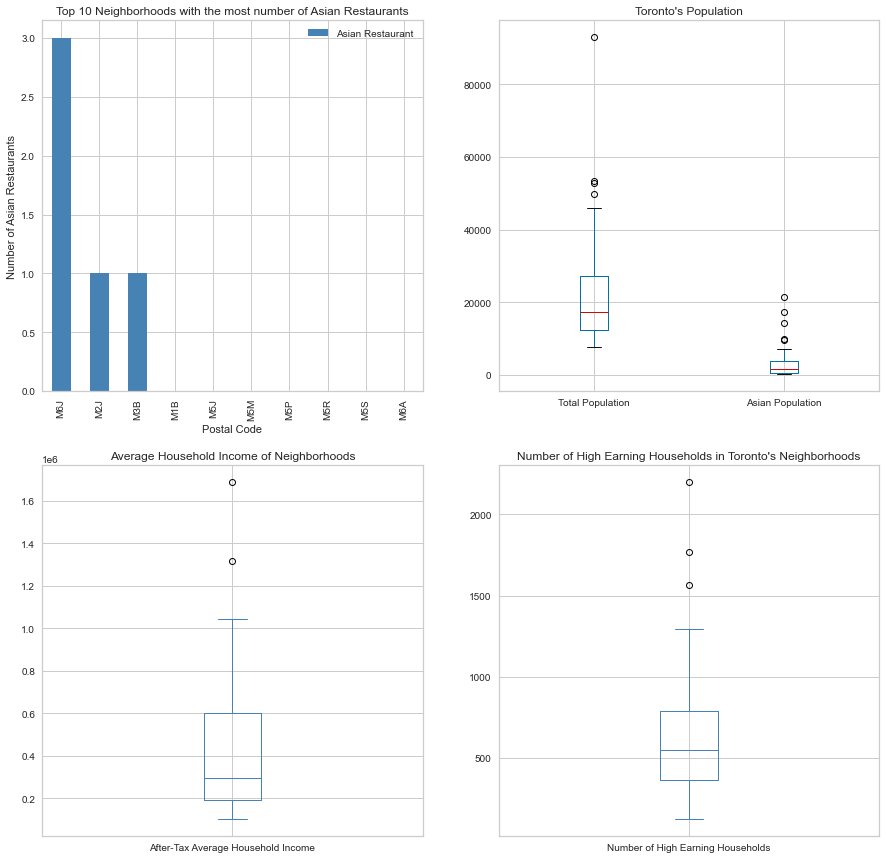

In [44]:
# Creating a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize = (15,15))

# Subplot 0
axs[0, 0].set_title('Top 10 Neighborhoods with the most number of Asian Restaurants')
axs[0, 0].set(ylabel = 'Number of Asian Restaurants')
# Creating a temp DataFrame consisting of top 10 neighborhoods with the most number of Asian Restaurants
temp = toronto_demograph_asian.sort_values('Asian Restaurant', ascending = False).head(10)
temp.plot(kind = 'bar', x = 'Postal Code', y = 'Asian Restaurant', color = 'steelblue', ax =axs[0, 0])

# Subplot 1 
axs[0, 1].set_title('Toronto\'s Population')
toronto_demograph_asian.plot(kind = 'box', x = 'Postal Code', y = ['Total Population', 'Asian Population'], ax = axs[0, 1])

# Subplot 2
axs[1, 0].set_title('Average Household Income of Neighborhoods')
toronto_demograph_asian.plot(kind = 'box', x = 'Postal Code', y = ['After-Tax Average Household Income'], color = 'steelblue', ax = axs[1, 0])

## Subplot 3
axs[1, 1].set_title('Number of High Earning Households in Toronto\'s Neighborhoods')
toronto_demograph_asian.plot(kind = 'box', x = 'Postal Code', y = 'Number of High Earning Households', color = 'steelblue', ax = axs[1, 1])

### 3. Clustering Toronto' Neighborhoods

Preprocessing data before preforming clustering

In [45]:
# Getting columns required for clustering
x = toronto_demograph_asian[toronto_demograph_asian.columns[4:9]]

# Scaling data to make its mean and sd 0 and 1 respectively. 
x = StandardScaler().fit_transform(x) 

C:\ProgramData\Anaconda3\envs\datascience\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


KElbowVisualizer(ax=<AxesSubplot:>, k=None, model=None)

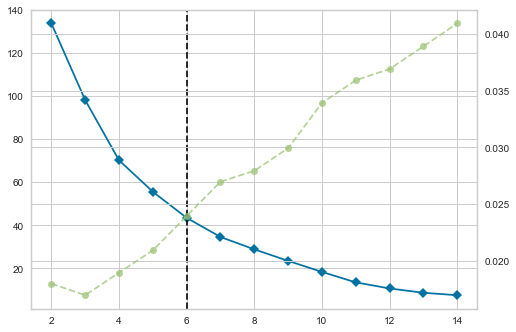

In [46]:
# Choosing best k using Elbow Method
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15))
visualizer.fit(x)
visualizer

Here we can see that the best k would be 6.

Let's perform clustering using this optimal k i.e. k = 6.

In [47]:
# Setting the optimal k
k = 6

# Initializing KMeans instance using optimal k
km = KMeans(n_clusters=k , init='k-means++') 

# Performing clustering
km.fit(x)

KMeans(n_clusters=6)

Labelling neighborhoods with labels retruned by KMeans.

In [48]:
toronto_demograph_asian['Label'] = km.labels_
toronto_demograph_asian.set_index('Neighborhood')

,Postal Code,Latitude,Longitude,Total Population,Asian Population,Number of High Earning Households,After-Tax Average Household Income,Asian Restaurant,Label
Neighborhood,,,,,,,,,
"Malvern, Rouge",M1B,43.806686,-79.194353,43794,17465,765,533202,0,5
"Rouge Hill, Port Union, Highland Creek",M1C,43.784535,-79.160497,46087,1750,1770,980578,0,4
"Guildwood, Morningside, West Hill",M1E,43.763573,-79.188711,9917,815,440,177062,0,3
Woburn,M1G,43.770992,-79.216917,53485,21545,855,629030,0,5
Scarborough Village,M1J,43.744734,-79.239476,16724,5520,230,185967,0,3
"Golden Mile, Clairlea, Oakridge",M1L,43.711112,-79.284577,13845,4800,125,134303,0,3
"Cliffside, Cliffcrest, Scarborough Village West",M1M,43.716316,-79.239476,15935,3000,565,248846,0,3
"Dorset Park, Wexford Heights, Scarborough Town Centre",M1P,43.757410,-79.273304,25003,7245,430,251476,0,3
Agincourt,M1S,43.794200,-79.262029,52870,9505,1070,705427,0,5


### 4. Analyzing Clusters

In [49]:
# Displaying these clusters on map using folium

# Toronto Lat/Lng
latitude = 43.6532
longitude = -79.3832

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_demograph_asian['Latitude'], toronto_demograph_asian['Longitude'], toronto_demograph_asian.index, toronto_demograph_asian['Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Cluster 0

In [50]:
toronto_demograph_asian[toronto_demograph_asian['Label'] == 0].describe(include = 'all')

,Postal Code,Neighborhood,Latitude,Longitude,Total Population,Asian Population,Number of High Earning Households,After-Tax Average Household Income,Asian Restaurant,Label
count,1,1,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
unique,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,M6M,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,43.691116,-79.476013,92980.0,14180.0,2200.0,1316396.0,0.0,0.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,43.691116,-79.476013,92980.0,14180.0,2200.0,1316396.0,0.0,0.0
25%,NaN,NaN,43.691116,-79.476013,92980.0,14180.0,2200.0,1316396.0,0.0,0.0
50%,NaN,NaN,43.691116,-79.476013,92980.0,14180.0,2200.0,1316396.0,0.0,0.0
75%,NaN,NaN,43.691116,-79.476013,92980.0,14180.0,2200.0,1316396.0,0.0,0.0


#### Cluster 1

In [51]:
toronto_demograph_asian[toronto_demograph_asian['Label'] == 1].describe(include = 'all')

,Postal Code,Neighborhood,Latitude,Longitude,Total Population,Asian Population,Number of High Earning Households,After-Tax Average Household Income,Asian Restaurant,Label
count,11,11,11.000000,11.000000,11.000000,11.000000,11.000000,1.100000e+01,11.000000,11.0
unique,11,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,M4K,Don Mills,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,43.700618,-79.391071,24290.000000,1859.545455,793.636364,6.108333e+05,0.090909,1.0
std,NaN,NaN,0.048628,0.066625,5893.633938,1536.273827,258.593222,2.362582e+05,0.301511,0.0
min,NaN,NaN,43.640816,-79.506944,9271.000000,205.000000,410.000000,3.040100e+05,0.000000,1.0
25%,NaN,NaN,43.665331,-79.415528,22401.500000,550.000000,625.000000,4.386695e+05,0.000000,1.0
50%,NaN,NaN,43.679557,-79.387383,25797.000000,1700.000000,730.000000,5.943120e+05,0.000000,1.0
75%,NaN,NaN,43.739594,-79.352188,27248.500000,2655.000000,937.500000,7.563550e+05,0.000000,1.0


#### Cluster 2

In [52]:
toronto_demograph_asian[toronto_demograph_asian['Label'] == 2].describe(include = 'all')

,Postal Code,Neighborhood,Latitude,Longitude,Total Population,Asian Population,Number of High Earning Households,After-Tax Average Household Income,Asian Restaurant,Label
count,1,1,1.000000,1.00000,1.0,1.0,1.0,1.0,1.0,1.0
unique,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,M6J,"Little Portugal, Trinity",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,43.647927,-79.41975,15559.0,445.0,480.0,202912.0,3.0,2.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,43.647927,-79.41975,15559.0,445.0,480.0,202912.0,3.0,2.0
25%,NaN,NaN,43.647927,-79.41975,15559.0,445.0,480.0,202912.0,3.0,2.0
50%,NaN,NaN,43.647927,-79.41975,15559.0,445.0,480.0,202912.0,3.0,2.0
75%,NaN,NaN,43.647927,-79.41975,15559.0,445.0,480.0,202912.0,3.0,2.0


#### Cluster 3

In [53]:
toronto_demograph_asian[toronto_demograph_asian['Label'] == 3].describe(include = 'all')

,Postal Code,Neighborhood,Latitude,Longitude,Total Population,Asian Population,Number of High Earning Households,After-Tax Average Household Income,Asian Restaurant,Label
count,24,24,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.0
unique,24,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,M2J,"Willowdale, Newtonbrook",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,43.707554,-79.387209,14277.041667,2191.875000,376.666667,208035.375000,0.041667,3.0
std,NaN,NaN,0.050252,0.104493,4212.784997,2512.185006,147.939960,68901.229983,0.204124,0.0
min,NaN,NaN,43.602414,-79.577201,7607.000000,230.000000,125.000000,103250.000000,0.000000,3.0
25%,NaN,NaN,43.672140,-79.454215,11298.000000,547.500000,256.250000,162467.000000,0.000000,3.0
50%,NaN,NaN,43.705883,-79.381751,14105.000000,825.000000,387.500000,195263.000000,0.000000,3.0
75%,NaN,NaN,43.747133,-79.314163,16132.250000,3091.250000,507.500000,251502.750000,0.000000,3.0


#### Cluster 4

In [54]:
toronto_demograph_asian[toronto_demograph_asian['Label'] == 4].describe(include = 'all')

,Postal Code,Neighborhood,Latitude,Longitude,Total Population,Asian Population,Number of High Earning Households,After-Tax Average Household Income,Asian Restaurant,Label
count,3,3,3.000000,3.000000,3.00000,3.000000,3.000000,3.000000e+00,3.0,3.0
unique,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,M7Y,"Rouge Hill, Port Union, Highland Creek",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,43.721932,-79.315606,41866.00000,1806.666667,1498.333333,1.196407e+06,0.0,4.0
std,NaN,NaN,0.060967,0.152220,10618.54797,1166.033161,310.416387,4.263294e+05,0.0,0.0
min,NaN,NaN,43.662744,-79.464763,29786.00000,670.000000,1160.000000,9.211510e+05,0.0,4.0
25%,NaN,NaN,43.690631,-79.393161,37936.50000,1210.000000,1362.500000,9.508645e+05,0.0,4.0
50%,NaN,NaN,43.718518,-79.321558,46087.00000,1750.000000,1565.000000,9.805780e+05,0.0,4.0
75%,NaN,NaN,43.751527,-79.241028,47906.00000,2375.000000,1667.500000,1.334036e+06,0.0,4.0


#### Cluster 5

In [55]:
toronto_demograph_asian[toronto_demograph_asian['Label'] == 5].describe(include = 'all')

,Postal Code,Neighborhood,Latitude,Longitude,Total Population,Asian Population,Number of High Earning Households,After-Tax Average Household Income,Asian Restaurant,Label
count,4,4,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.0,4.0
unique,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,M1G,"Steeles West, L'Amoreaux West",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,43.792851,-79.247922,48535.500000,13938.750000,892.500000,599260.500000,0.0,5.0
std,NaN,NaN,0.015444,0.054758,5366.611873,6703.751903,128.225063,84467.230887,0.0,0.0
min,NaN,NaN,43.770992,-79.318389,43794.000000,7240.000000,765.000000,529383.000000,0.0,5.0
25%,NaN,NaN,43.788398,-79.276119,43943.250000,8938.750000,832.500000,532247.250000,0.0,5.0
50%,NaN,NaN,43.796863,-79.239473,48431.500000,13485.000000,867.500000,581116.000000,0.0,5.0
75%,NaN,NaN,43.801315,-79.211276,53023.750000,18485.000000,927.500000,648129.250000,0.0,5.0


### 5. Conclusion

It looks like cluster 1 is the one closest to our ideal cluster(as defined in the beginning), so let's explore it further.

In [58]:
opt_rest = toronto_demograph_asian[toronto_demograph_asian['Label'] == 1].sort_values('Asian Restaurant', ascending = False).reset_index().drop(columns = ['index'])
opt_rest.head()

,Postal Code,Neighborhood,Latitude,Longitude,Total Population,Asian Population,Number of High Earning Households,After-Tax Average Household Income,Asian Restaurant,Label
0,M3B,Don Mills,43.745906,-79.352188,27051,2890,645,414411,1,1
1,M1T,"Clarks Corners, Tam O'Shanter, Sullivan",43.781638,-79.304302,27446,4690,585,475647,0,1
2,M3J,"Northwood Park, York University",43.767980,-79.487262,30531,4175,730,462928,0,1
3,M4E,The Beaches,43.676357,-79.293031,21567,645,955,659192,0,1
4,M4K,"The Danforth West, Riverdale",43.679557,-79.352188,26846,1735,1295,594312,0,1


Here we can see that first three of the aforementioned neighborhoods are the closest to our ideal neighborhood because it has:
1. Medium number of high earning households.
2. Medium average household income.
3. High percentage of Asian population.
4. Low to medium competition (compared to all other neighborhoods)

So, client can consider any of these 3 neighborhoods for opening his resaturant.